<center>
<img src="../../ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm_notebook
import pickle as pkl
from collections import defaultdict

Reading original data

In [2]:
PATH_TO_DATA = ('./data')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [3]:
site_dict = pkl.load(open('./data/site_dic.pkl', 'rb'))
site_dict_inv = defaultdict(str, [(v, k) for (k, v) in site_dict.items()])

In [4]:
train_df.sort_values(by='time1', inplace=True)

In [36]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

Separate target feature 

In [5]:
y = train_df['target']

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [6]:
X = train_df.drop('target', axis=1)
test = test_df.copy()

In [7]:
times = ['time%s' % i for i in np.arange(1, 11)]
sites = ['site%s' % i for i in np.arange(1, 11)]

In [8]:
X[times] = X[times].fillna(0).apply(pd.to_datetime)
test[times] = test[times].fillna(0).apply(pd.to_datetime)

In [9]:
X[sites] = X[sites].fillna(0).astype('int')
test[sites] = test[sites].fillna(0).astype('int')

In [10]:
for i in tqdm_notebook(np.arange(1, 11)):
    X['site_name%s' % i] = X['site%s' % i].apply(lambda i: ' '.join(site_dict_inv[i].split('.')))
    test['site_name%s' % i] = test['site%s' % i].apply(lambda i: ' '.join(site_dict_inv[i].split('.')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [11]:
X.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site_name1,site_name2,site_name3,site_name4,site_name5,site_name6,site_name7,site_name8,site_name9,site_name10
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,...,safebrowsing clients google com,safebrowsing-cache google com,,,,,,,,
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,1970-01-01 00:00:00,...,safebrowsing clients google com,safebrowsing-cache google com,safebrowsing clients google com,safebrowsing-cache google com,,,,,,
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,www apache org,www apache org,download eclipse org,www apache org,www apache org,www webtide com,download oracle com,javadl-esd-secure oracle com,www caucho com,www apache org
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,www webtide com,download oracle com,www caucho com,download oracle com,www webtide com,www apache org,public dhe ibm com,www webtide com,www apache org,www apache org
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,public dhe ibm com,jope ow2 org,download oracle com,public dhe ibm com,jope ow2 org,master dl sourceforge net,www apache org,download eclipse org,www apache org,public dhe ibm com


In [12]:
X['all_sites'] = [' '.join(row) for row in X[sites].astype(str).values]
test['all_sites'] = [' '.join(row) for row in test[sites].astype(str).values]

In [13]:
site_names = ['site_name%s' % i for i in np.arange(1, 11)]
X_all_sites_names = [(' '.join(row)).strip() for row in X[site_names].values]
test_all_sites_names = [(' '.join(row)).strip() for row in test[site_names].values]

In [100]:
stop_words = ['www', 'com']
tf_idf = TfidfVectorizer(ngram_range=(1, 4))
tf_idf.fit(X_all_sites_names)
X_tfidf = tf_idf.transform(X_all_sites_names)
test_tfidf = tf_idf.transform(test_all_sites_names)

In [136]:
tf_idf = TfidfVectorizer(ngram_range=(1, 4))
tf_idf.fit(X['all_sites'])
X_tfidf = tf_idf.transform(X['all_sites'])
test_tfidf = tf_idf.transform(test['all_sites'])

In [15]:
count_vec = CountVectorizer(ngram_range=(1, 3))
count_vec.fit(X_all_sites_names)
X_count_vec = count_vec.transform(X_all_sites_names)
test_count_vec = count_vec.transform(test_all_sites_names)

In [16]:
full_df = pd.concat([train_df.drop('target', axis=1), test_df])
idx_split = train_df.shape[0]
full_sites = full_df[sites]
sites_flatten = full_sites.values.flatten()
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                np.arange(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

X_full_sites_sparse = full_sites_sparse[:idx_split]
test_full_sites_sparse = full_sites_sparse[idx_split:]

Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [40]:
def get_day_part(time):
    h = time.hour
    if h < 12:
        return 1
    elif h < 19:
        return 2
    else:
        return 3

X['day_part'] = X['time1'].apply(get_day_part)
test['day_part'] = test['time1'].apply(get_day_part)

In [89]:
alice_hour = ['12', '13', '16', '17', '18']

X['day_part_alice'] = [int(row.hour in alice_hour) for row in
                                         tqdm_notebook(X['time1'])]
test['day_part_alice'] = [int(row.hour in alice_hour) for row in
                                         tqdm_notebook(test['time1'])]

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

In [122]:
def make_harmonic_features_cos(time, period=24):
    value = time.hour
    value *= 2 * np.pi / period
    return np.cos(value)

def make_harmonic_features_sin(time, period=24):
    value = time.hour
    value *= 2 * np.pi / period
    return np.sin(value)

hour_coses = ['hour_cos%s' % i for i in np.arange(1, 11)]
hour_sins = ['hour_sin%s' % i for i in np.arange(1, 11)]

for i in tqdm_notebook(np.arange(1, 11)):
    X['hour_cos%s' % i] = X['time%s' % i].apply(make_harmonic_features_cos)
    X['hour_sin%s' % i] = X['time%s' % i].apply(make_harmonic_features_sin)
    test['hour_cos%s' % i] = test['time%s' % i].apply(make_harmonic_features_cos)
    test['hour_sin%s' % i] = test['time%s' % i].apply(make_harmonic_features_sin)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [54]:
X['unique_sites'] = [np.unique(row[row != 0]).shape[0] for row in 
                     tqdm_notebook(X[['site' + str(i) for i in np.arange(1, 11)]].values)]
test['unique_sites'] = [np.unique(row[row != 0]).shape[0] for row in 
                         tqdm_notebook(test[['site' + str(i) for i in np.arange(1, 11)]].values)]

X['visited'] = [row[row != 0].shape[0] for row in 
                     tqdm_notebook(X[['site' + str(i) for i in np.arange(1, 11)]].values)]
test['visited'] = [row[row != 0].shape[0] for row in 
                         tqdm_notebook(test[['site' + str(i) for i in np.arange(1, 11)]].values)]

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

In [73]:
def get_duration(row):
    zero = np.datetime64('1970-01-01T00:00:00.000000000')
    cor = [r for r in row if r != zero]
    return (cor[-1] - cor[0])
    
X['duration'] = [get_duration(row) for row in
                     tqdm_notebook(X[['time%s' % i for i in np.arange(1, 11)]].values)]
test['duration'] = [get_duration(row) for row in
                     tqdm_notebook(test[['time%s' % i for i in np.arange(1, 11)]].values)]

X['duration'] = X['duration'].apply(lambda s: int(s.total_seconds()) + 1)
test['duration'] = test['duration'].apply(lambda s: int(s.total_seconds()) + 1)

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

In [47]:
X['weekday'] = [row.weekday() for row in
                                         tqdm_notebook(X['time1'])]
test['weekday'] = [row.weekday() for row in
                                         tqdm_notebook(test['time1'])]

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

In [107]:
X['year'] = X['time1'].apply(lambda x: x.year - 2013)
test['year'] = test['time1'].apply(lambda x: x.year - 2013)

In [75]:
top_weekday = [0, 1, 3, 4]

X['weekday_alice'] = [int(row.weekday() in top_weekday) for row in
                                         tqdm_notebook(X['time1'])]
test['weekday_alice'] = [int(row.weekday() in top_weekday) for row in
                                         tqdm_notebook(test['time1'])]

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

In [150]:
alice_sites_count = defaultdict(int)
for row in tqdm_notebook(train_df[train_df['target'] == 1][sites].values):
    for site in row:
        alice_sites_count[site] += 1
alice_sites = sorted([(k, v) for (k, v) in alice_sites_count.items()], key=lambda x: x[1], reverse=True)
alice_top_sites = [i[0] for i in alice_sites if i[1] > 10]

X['visit_top_site'] = X[sites].apply(lambda row: any(i in alice_top_sites for i in row), axis=1).astype(int)
test['visit_top_site'] = test[sites].apply(lambda row: any(i in alice_top_sites for i in row), axis=1).astype(int)

HBox(children=(IntProgress(value=0, max=2297), HTML(value='')))

In [44]:
X['start_hour'] = X['time1'].apply(lambda x: x.hour)
test['start_hour'] = test['time1'].apply(lambda x: x.hour)

In [102]:
def make_harmonic_features_cos(time, period=24):
    value = time.hour
    value *= 2 * np.pi / period
    return np.cos(value)

def make_harmonic_features_sin(time, period=24):
    value = time.hour
    value *= 2 * np.pi / period
    return np.sin(value)

X['start_hour_cos'] = X['time1'].apply(make_harmonic_features_cos)
X['start_hour_sin'] = X['time1'].apply(make_harmonic_features_sin)
test['start_hour_cos'] = test['time1'].apply(make_harmonic_features_cos)
test['start_hour_sin'] = test['time1'].apply(make_harmonic_features_sin)

In [78]:
X['site_per_sec'] = X[['duration', 'visited']].apply(lambda x: x[0] / x[1], axis=1)
test['site_per_sec'] = test[['duration', 'visited']].apply(lambda x: x[0] / x[1], axis=1)

In [125]:
X.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,hour_cos6,hour_sin6,hour_cos7,hour_sin7,hour_cos8,hour_sin8,hour_cos9,hour_sin9,hour_cos10,hour_sin10
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,...,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,1970-01-01 00:00:00,...,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,-0.5,0.866025,-0.5,0.866025,-0.5,0.866025,-0.5,0.866025,-0.5,0.866025
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,-0.5,0.866025,-0.5,0.866025,-0.5,0.866025,-0.5,0.866025,-0.5,0.866025
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,-0.5,0.866025,-0.5,0.866025,-0.5,0.866025,-0.5,0.866025,-0.5,0.866025


In [109]:
X.columns

Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site4', 'time4',
       'site5', 'time5', 'site6', 'time6', 'site7', 'time7', 'site8', 'time8',
       'site9', 'time9', 'site10', 'time10', 'site_name1', 'site_name2',
       'site_name3', 'site_name4', 'site_name5', 'site_name6', 'site_name7',
       'site_name8', 'site_name9', 'site_name10', 'all_sites', 'day_part',
       'unique_sites', 'duration', 'visit_top_site', 'start_hour', 'weekday',
       'year', 'visited', 'site_per_sec', 'start_hour_cos', 'start_hour_sin'],
      dtype='object')

In [126]:
X[site_names]

,site_name1,site_name2,site_name3,site_name4,site_name5,site_name6,site_name7,site_name8,site_name9,site_name10
session_id,,,,,,,,,,
21669,safebrowsing clients google com,safebrowsing-cache google com,,,,,,,,
54843,safebrowsing clients google com,safebrowsing-cache google com,safebrowsing clients google com,safebrowsing-cache google com,,,,,,
77292,www apache org,www apache org,download eclipse org,www apache org,www apache org,www webtide com,download oracle com,javadl-esd-secure oracle com,www caucho com,www apache org
114021,www webtide com,download oracle com,www caucho com,download oracle com,www webtide com,www apache org,public dhe ibm com,www webtide com,www apache org,www apache org
146670,public dhe ibm com,jope ow2 org,download oracle com,public dhe ibm com,jope ow2 org,master dl sourceforge net,www apache org,download eclipse org,www apache org,public dhe ibm com
242171,master dl sourceforge net,public dhe ibm com,download jboss org,www apache org,public dhe ibm com,www apache org,download jboss org,dfn dl sourceforge net,www apache org,public dhe ibm com
57157,download jboss org,public dhe ibm com,www apache org,download jboss org,dfn dl sourceforge net,public dhe ibm com,download jboss org,www apache org,download jboss org,netcologne dl sourceforge net
240201,www apache org,public dhe ibm com,heanet dl sourceforge net,download jboss org,www apache org,heanet dl sourceforge net,www apache org,kent dl sourceforge net,optimate dl sourceforge net,kent dl sourceforge net
210686,www apache org,kent dl sourceforge net,www apache org,www apache org,dfn dl sourceforge net,heanet dl sourceforge net,www apache org,www apache org,www apache org,download oracle com


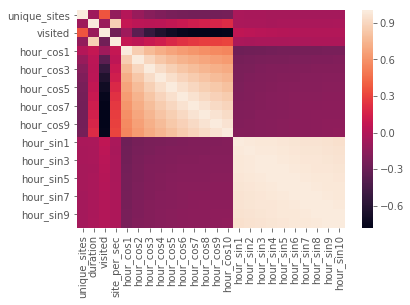

In [124]:
sns.heatmap(X[['unique_sites', 'duration', 'visited', 'site_per_sec'] +\
              hour_coses + hour_sins].corr())

Scale this features and combine then with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

In [151]:
ohe = OneHotEncoder()
ohe_columns = ['day_part', 'weekday']
ohe.fit(X[ohe_columns])
X_ohe = ohe.transform(X[ohe_columns])
test_ohe = ohe.transform(test[ohe_columns])

In [162]:
ss = StandardScaler()
mm = MinMaxScaler()
columns = ['unique_sites', 'duration', 'site_per_sec', 'visited'] +\
            hour_coses + hour_sins
        
X_numeric = X[columns]
test_numeric = test[columns]

ss.fit(X_numeric.append(test_numeric))
X_numeric = ss.transform(X_numeric)
test_numeric = ss.transform(test_numeric)

# mm.fit(X_numeric.append(test_numeric))
# X_numeric = mm.transform(X_numeric)
# test_numeric = mm.transform(test_numeric)

In [153]:
bin_columns = ['visit_top_site', 'year']
X_binary = X[bin_columns]
test_binary = test[bin_columns]

In [154]:
X_at_all = hstack([X_tfidf, X_binary, X_numeric, X_ohe]).tocsr()
test_at_all = hstack([test_tfidf, test_binary, test_numeric, test_ohe]).tocsr()

Perform cross-validation with logistic regression.

In [114]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.8):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred_val = lr.predict_proba(X[idx:, :])[:, 1]
    y_pred_train = lr.predict_proba(X[:idx, :])[:, 1]
    # Calculate the quality
    score_val = roc_auc_score(y[idx:], y_pred_val)
    score_train = roc_auc_score(y[:idx], y_pred_train)
    return (score_train, score_val)

In [155]:
%%time
print(get_auc_lr_valid(X_at_all, y))

(0.982884210694916, 0.9448670293828533)
CPU times: user 31.3 s, sys: 907 ms, total: 32.2 s
Wall time: 16.3 s


In [156]:
train_score = []
val_score = []
C = [0.01, 1, 2, 3, 7, 10, 15, 20, 30]
for c in tqdm_notebook(C):
    score = get_auc_lr_valid(X_at_all, y, C=c, ratio=0.8)
    train_score.append(score[0])
    val_score.append(score[1])

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

Text(0.5,0,'C')

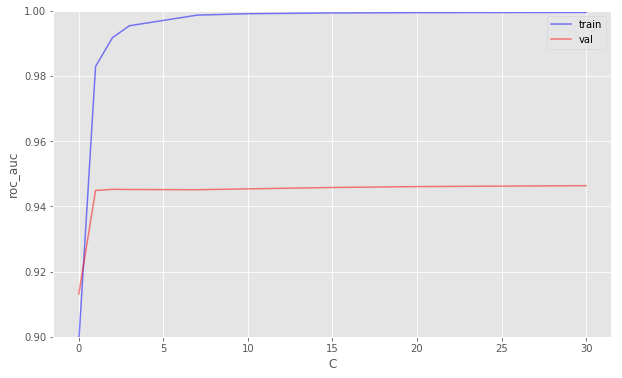

In [157]:
(fig, ax) = plt.subplots(figsize=(10, 6))
ax.plot(C, train_score, alpha=0.5, color='blue', label='train')
ax.plot(C, val_score, alpha=0.5, color='red', label='val')
ax.legend(loc='best')
ax.set_ylim([0.9,1])
ax.set_ylabel('roc_auc')
ax.set_xlabel('C')

In [158]:
list(zip(C, val_score))

[(0.01, 0.9131193175525821),
 (1, 0.9448670293828533),
 (2, 0.9452256048618277),
 (3, 0.945163065476103),
 (7, 0.9450971571714606),
 (10, 0.9453578502426112),
 (15, 0.9457735135839711),
 (20, 0.9460525825764904),
 (30, 0.9463431671464007)]

In [159]:
%time
clf = LogisticRegression(random_state=17, n_jobs=-1, C=1)
clf.fit(X_at_all, y)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Make prediction for the test set and form a submission file.

In [160]:
test_pred = clf.predict_proba(test_at_all)

In [98]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [161]:
write_to_submission_file(test_pred[:, 1],
                         './submissions/tfidf1-4-numbers+ss+c1.csv')

### CatBoost

In [163]:
import catboost

In [176]:
def get_auc_lr_valid_catboost(X, y, iterations = 100, seed=17, ratio = 0.8, cat_features = []):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    clf = catboost.CatBoostClassifier(random_seed=seed, iterations=iterations, eval_metric='AUC')
    clf.fit(X.iloc[:idx, :], y[:idx], cat_features=cat_features, eval_set=(X.iloc[idx:], y[idx:]))
    # Prediction for validation set
    y_pred_val = clf.predict_proba(X.iloc[idx:, :])[:, 1]
    y_pred_train = clf.predict_proba(X.iloc[:idx, :])[:, 1]
    # Calculate the quality
    score_val = roc_auc_score(y[idx:], y_pred_val)
    score_train = roc_auc_score(y[:idx], y_pred_train)
    return (score_train, score_val)

In [168]:
X_catboost = X[sites + ['day_part', 'weekday'] + ['unique_sites', 'duration', 'site_per_sec', 'visited'] +\
            hour_coses + hour_sins + ['visit_top_site', 'year']]
test_catboost = test[sites + ['day_part', 'weekday'] + ['unique_sites', 'duration', 'site_per_sec', 'visited'] +\
            hour_coses + hour_sins + ['visit_top_site', 'year']]

cat_features = [i for i in np.arange(len(X_catboost.columns)) if 
                               X_catboost.columns[i] in sites + ['day_part', 'weekday']]

In [177]:
%%time
print(get_auc_lr_valid_catboost(X_catboost, y))

0:	learn: 0.8656584	test: 0.9435787	best: 0.9435787 (0)	total: 178ms	remaining: 17.6s
1:	learn: 0.8850878	test: 0.9472004	best: 0.9472004 (1)	total: 357ms	remaining: 17.5s
2:	learn: 0.8884128	test: 0.9513627	best: 0.9513627 (2)	total: 565ms	remaining: 18.3s
3:	learn: 0.8881148	test: 0.9500632	best: 0.9513627 (2)	total: 752ms	remaining: 18s
4:	learn: 0.8890681	test: 0.9494862	best: 0.9513627 (2)	total: 941ms	remaining: 17.9s
5:	learn: 0.8889048	test: 0.9512078	best: 0.9513627 (2)	total: 1.11s	remaining: 17.4s
6:	learn: 0.8890193	test: 0.9507189	best: 0.9513627 (2)	total: 1.3s	remaining: 17.3s
7:	learn: 0.8899164	test: 0.9523383	best: 0.9523383 (7)	total: 1.51s	remaining: 17.4s
8:	learn: 0.8902226	test: 0.9517894	best: 0.9523383 (7)	total: 1.72s	remaining: 17.4s
9:	learn: 0.8908532	test: 0.9520290	best: 0.9523383 (7)	total: 1.92s	remaining: 17.3s
10:	learn: 0.8908336	test: 0.9527218	best: 0.9527218 (10)	total: 2.1s	remaining: 17s
11:	learn: 0.8908320	test: 0.9530556	best: 0.9530556 (11)	

94:	learn: 0.9675395	test: 0.9652238	best: 0.9654579 (92)	total: 19.2s	remaining: 1.01s
95:	learn: 0.9677590	test: 0.9653417	best: 0.9654579 (92)	total: 19.4s	remaining: 807ms
96:	learn: 0.9679434	test: 0.9656388	best: 0.9656388 (96)	total: 19.6s	remaining: 605ms
97:	learn: 0.9681865	test: 0.9657414	best: 0.9657414 (97)	total: 19.8s	remaining: 403ms
98:	learn: 0.9684150	test: 0.9657823	best: 0.9657823 (98)	total: 20s	remaining: 202ms
99:	learn: 0.9685953	test: 0.9659021	best: 0.9659021 (99)	total: 20.2s	remaining: 0us

bestTest = 0.9659021303
bestIteration = 99

(0.9685953097657298, 0.9659021303328148)
CPU times: user 54.4 s, sys: 1.96 s, total: 56.4 s
Wall time: 23.9 s


In [178]:
clf = catboost.CatBoostClassifier(random_seed=17, iterations=100)
clf.fit(X_catboost, y)
test_pred = clf.predict_proba(test_catboost)

0:	learn: 0.6065706	total: 140ms	remaining: 13.9s
1:	learn: 0.5314103	total: 285ms	remaining: 14s
2:	learn: 0.4663853	total: 444ms	remaining: 14.4s
3:	learn: 0.4099603	total: 581ms	remaining: 14s
4:	learn: 0.3612878	total: 730ms	remaining: 13.9s
5:	learn: 0.3191284	total: 877ms	remaining: 13.7s
6:	learn: 0.2830298	total: 1.03s	remaining: 13.7s
7:	learn: 0.2517543	total: 1.18s	remaining: 13.6s
8:	learn: 0.2250781	total: 1.33s	remaining: 13.5s
9:	learn: 0.2020393	total: 1.49s	remaining: 13.5s
10:	learn: 0.1822801	total: 1.68s	remaining: 13.6s
11:	learn: 0.1651987	total: 1.86s	remaining: 13.6s
12:	learn: 0.1503256	total: 2.05s	remaining: 13.7s
13:	learn: 0.1373137	total: 2.24s	remaining: 13.7s
14:	learn: 0.1261361	total: 2.39s	remaining: 13.6s
15:	learn: 0.1142851	total: 2.55s	remaining: 13.4s
16:	learn: 0.1057994	total: 2.72s	remaining: 13.3s
17:	learn: 0.0985398	total: 2.88s	remaining: 13.1s
18:	learn: 0.0921369	total: 3.04s	remaining: 13s
19:	learn: 0.0863029	total: 3.17s	remaining: 12

In [179]:
write_to_submission_file(test_pred[:, 1],
                         './submissions/catboost_iter100.csv')